In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

import pymc as pm
import pymc.math as pmth # Math with pytensors

import arviz as az # pymc integrated plotting library
import corner # Corner plots

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Expected flux as a function of time
def model_flux(t, t0, b, A, alpha):
    if t < t0:
        return b
    else:
        return b + A * np.exp(-alpha * (t - t0))

In [3]:
# transient[measurment_index][quantity_index], quantity_index = (0, 1, 2): (time, flux, flux_err)
transient = np.load("transient.npy")

N = len(transient)

# transient[quantity_index][measurment_index]
transient = np.swapaxes(transient, 0, 1)

time_data = transient[0]
flux_data = transient[1]
flux_err_data = transient[2]

# Errors are homoschedastic
sigma = flux_err_data[0]

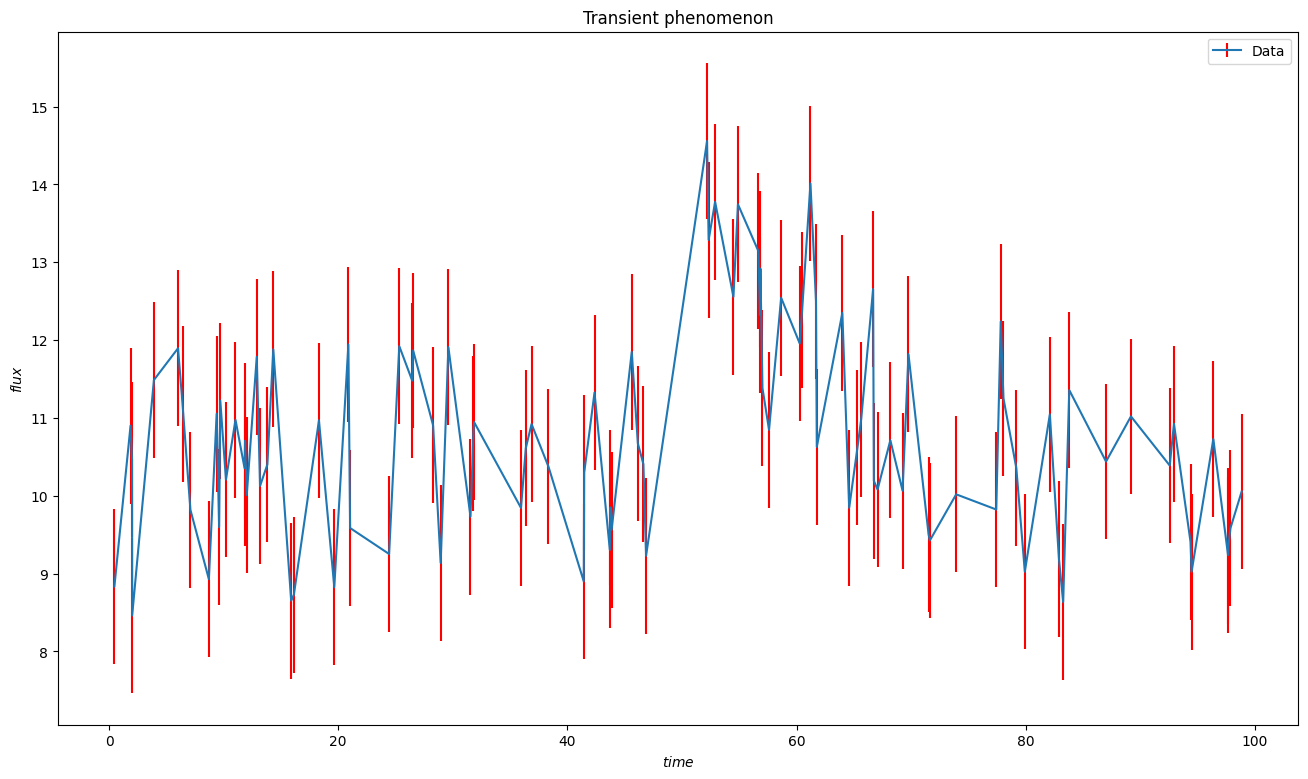

In [4]:
# Plot the data
fig, ax = plt.subplots(figsize=(16,9))

ax.set_title("Transient phenomenon")
ax.set_xlabel("$time$")
ax.set_ylabel("$flux$")

ax.errorbar(time_data, flux_data, yerr=flux_err_data, ecolor='red', label='Data')

ax.legend()

plt.show()

In [5]:
# Model by eye
t0 = 50
b = 10
A = 5
alpha = 0.1

grid_n_points = 10000

time_grid = np.linspace(np.min(time_data), np.max(time_data), grid_n_points)

flux_model = np.array([model_flux(t, t0, b, A, alpha) for t in time_grid])

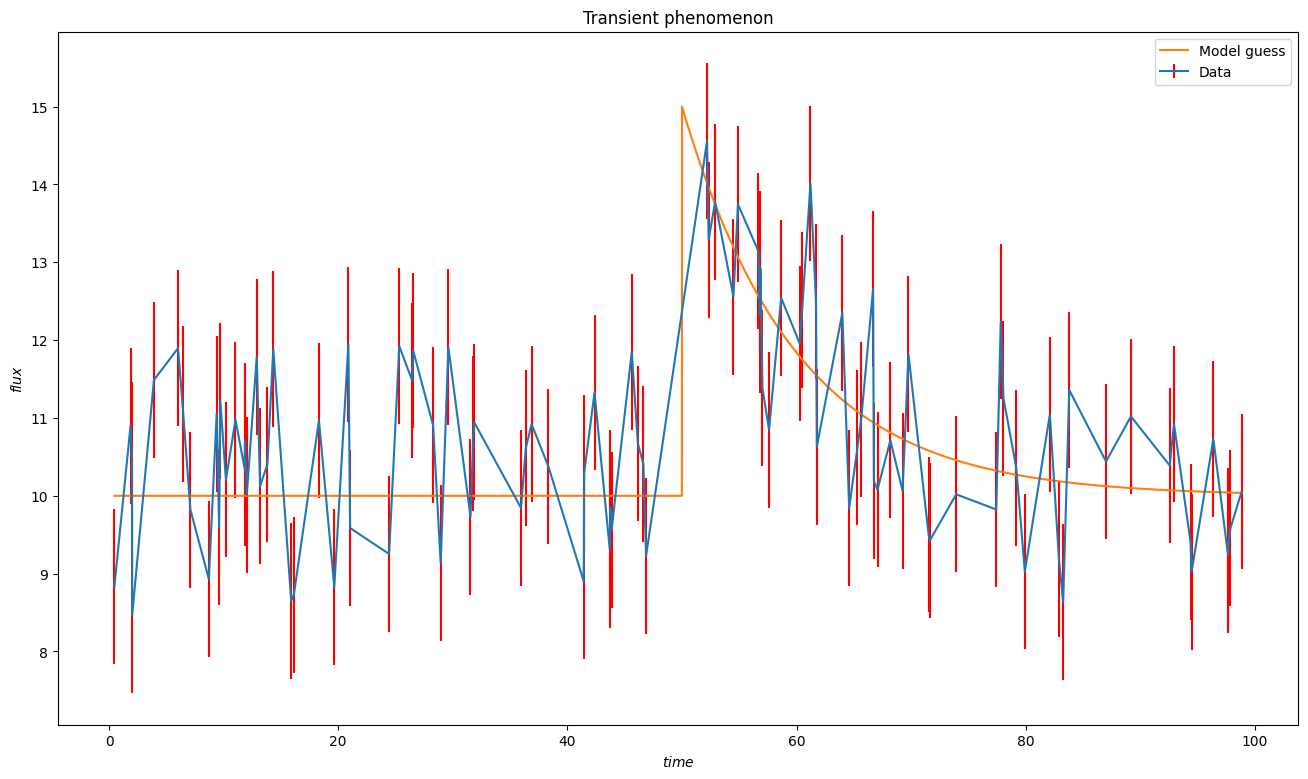

In [6]:
# Plot the guess for the model along with the data
fig, ax = plt.subplots(figsize=(16,9))

ax.set_title("Transient phenomenon")
ax.set_xlabel("$time$")
ax.set_ylabel("$flux$")

ax.errorbar(time_data, flux_data, yerr=flux_err_data, ecolor='red', label='Data')
ax.plot(time_grid, flux_model, label='Model guess')

ax.legend()

plt.show()

In [7]:
# Log-likelihood of the data set given the model (by eye)
grid_n_points = 10000

logL = np.zeros(grid_n_points)

flux_grid = np.linspace(np.min(flux_data), np.max(flux_data), grid_n_points)

for i in range(N):
    logL += np.log(stats.norm.pdf(flux_grid, flux_model[i], sigma))

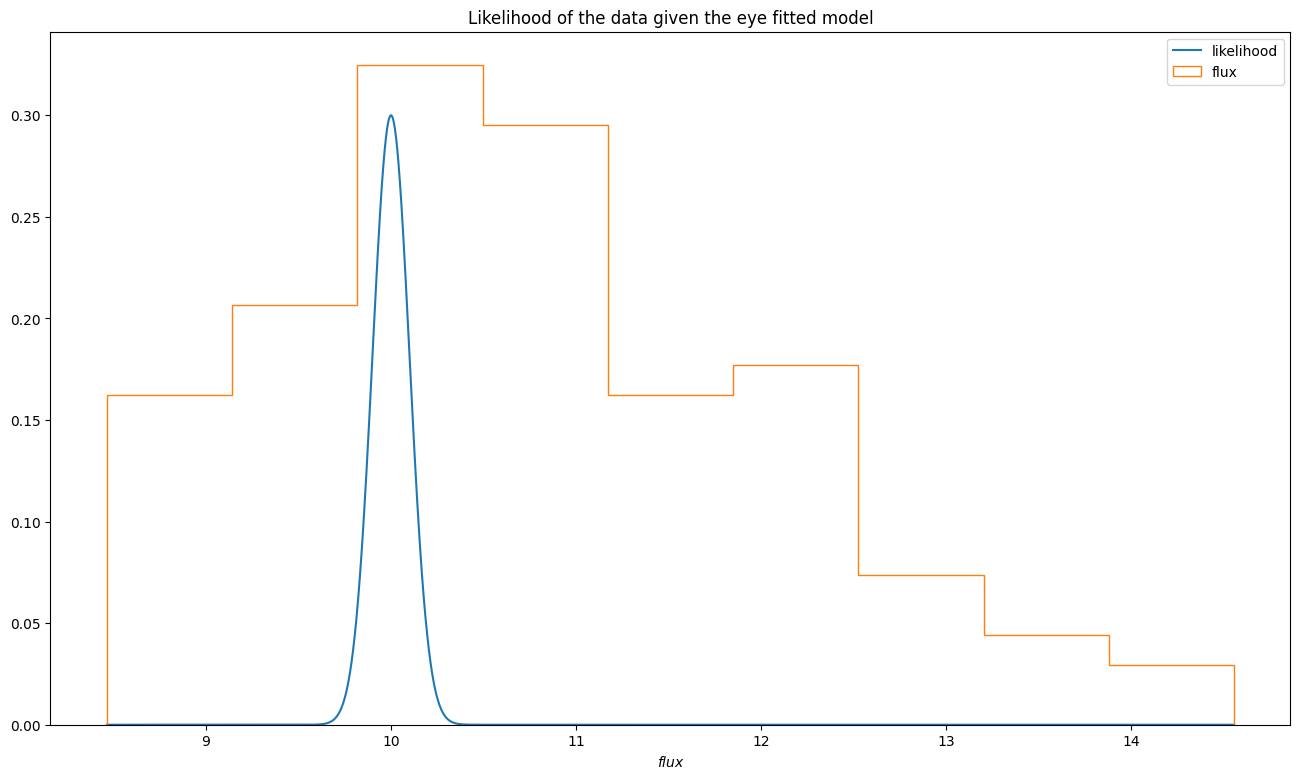

In [8]:
# Plot the likelihood
fig, ax = plt.subplots(figsize=(16,9))

ax.set_title("Likelihood of the data given the eye fitted model")
ax.set_xlabel("$flux$")

# Rescale the likelihood
L =  np.exp(logL)
scale_factor = 0.3 / np.max(L)
rescaled_L = L * scale_factor

ax.plot(flux_grid, rescaled_L, label='likelihood')
ax.hist(flux_data, bins='auto', density=True, label='flux', histtype='step')

ax.legend()

plt.show()

In [9]:
# MCMC sampling using pymc
with pm.Model():
    # Data conversion to pytensors
    time = pm.Data("time", time_data)
    flux = pm.Data("flux_data", flux_data)

    # Parameters space
    t0 = pm.Uniform('t0', 0, 100)
    b = pm.Uniform('b', 0, 50)
    A = pm.Uniform('A', 0, 50)
    log_alpha = pm.Uniform('log_alpha', -5, 5)

    # See model_flux() at the beginning of the notebook to understand better
    # The whole point is that pytensors are tricky
    # I tried other strategies to code the expected flux as a function of time, but this is the
    # only one that worked. For istance I tried a simple if-else using pmth.lt() and also a lambda
    # function tu be passed directly to pm.Normal() below to the 'mu' parameter (still using pmth.lt())
    # See the documentation: https://www.pymc.io/projects/docs/en/stable/api/math.html (Apr 2024)
    # 
    # Also, using pmth.exp() instead of np.exp() seems to produce different behaviors
    expected_flux = pmth.where(time < t0, b, b + A * np.exp(-np.exp(log_alpha) * (time - t0)))

    # Likelihood of the data given the model. Errors are homoschedastic
    likelihood = pm.Normal('flux', mu=expected_flux, sigma=sigma, observed=flux)

    trace = pm.sample(draws=2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t0, b, A, log_alpha]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 616 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'log_alpha'}>,
        <Axes: title={'center': 'log_alpha'}>],
       [<Axes: title={'center': 't0'}>, <Axes: title={'center': 't0'}>]],
      dtype=object)

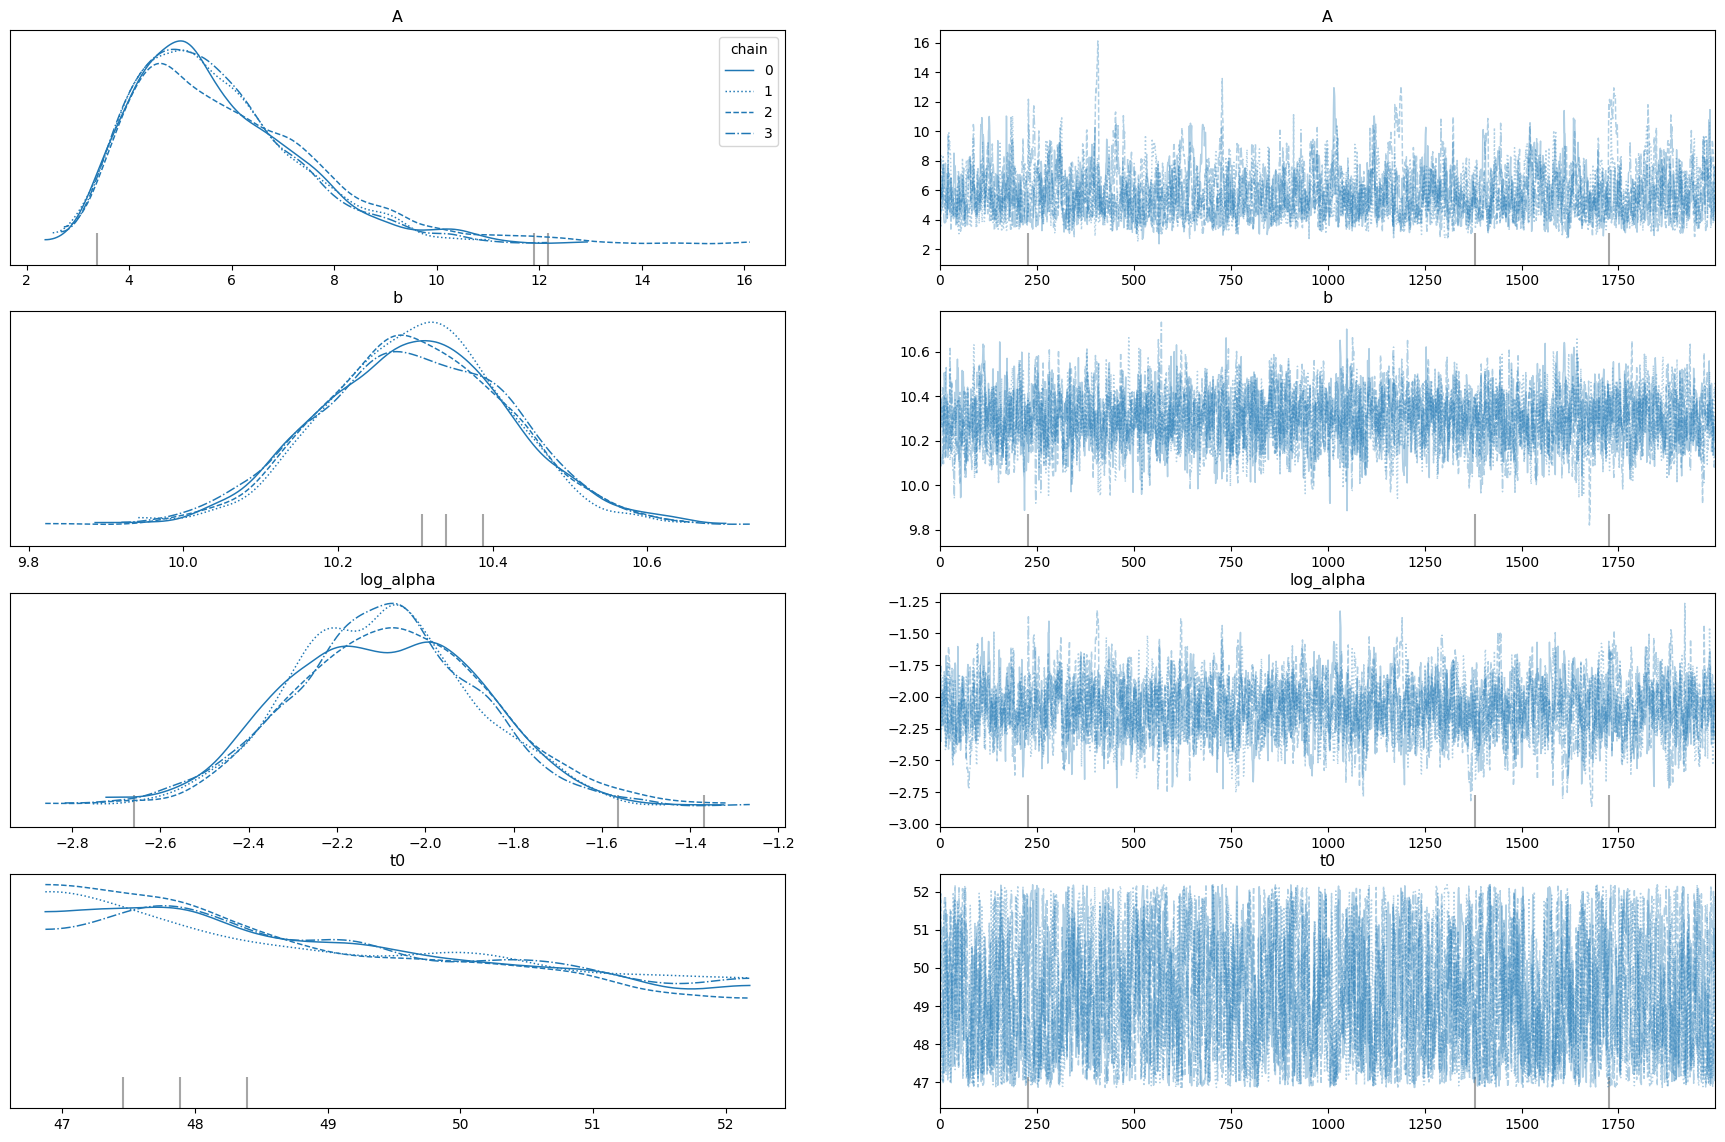

In [10]:
# Quick visualization using arviz library
# combined=True combines all the chains into one
# Keep combined=False to look at different chains
az.plot_trace(trace, figsize=(22,14), combined=False, legend=True)

array([[<Axes: title={'center': 'A\n0'}>,
        <Axes: title={'center': 'A\n1'}>,
        <Axes: title={'center': 'A\n2'}>,
        <Axes: title={'center': 'A\n3'}>],
       [<Axes: title={'center': 'b\n0'}>,
        <Axes: title={'center': 'b\n1'}>,
        <Axes: title={'center': 'b\n2'}>,
        <Axes: title={'center': 'b\n3'}>],
       [<Axes: title={'center': 'log_alpha\n0'}>,
        <Axes: title={'center': 'log_alpha\n1'}>,
        <Axes: title={'center': 'log_alpha\n2'}>,
        <Axes: title={'center': 'log_alpha\n3'}>],
       [<Axes: title={'center': 't0\n0'}>,
        <Axes: title={'center': 't0\n1'}>,
        <Axes: title={'center': 't0\n2'}>,
        <Axes: title={'center': 't0\n3'}>]], dtype=object)

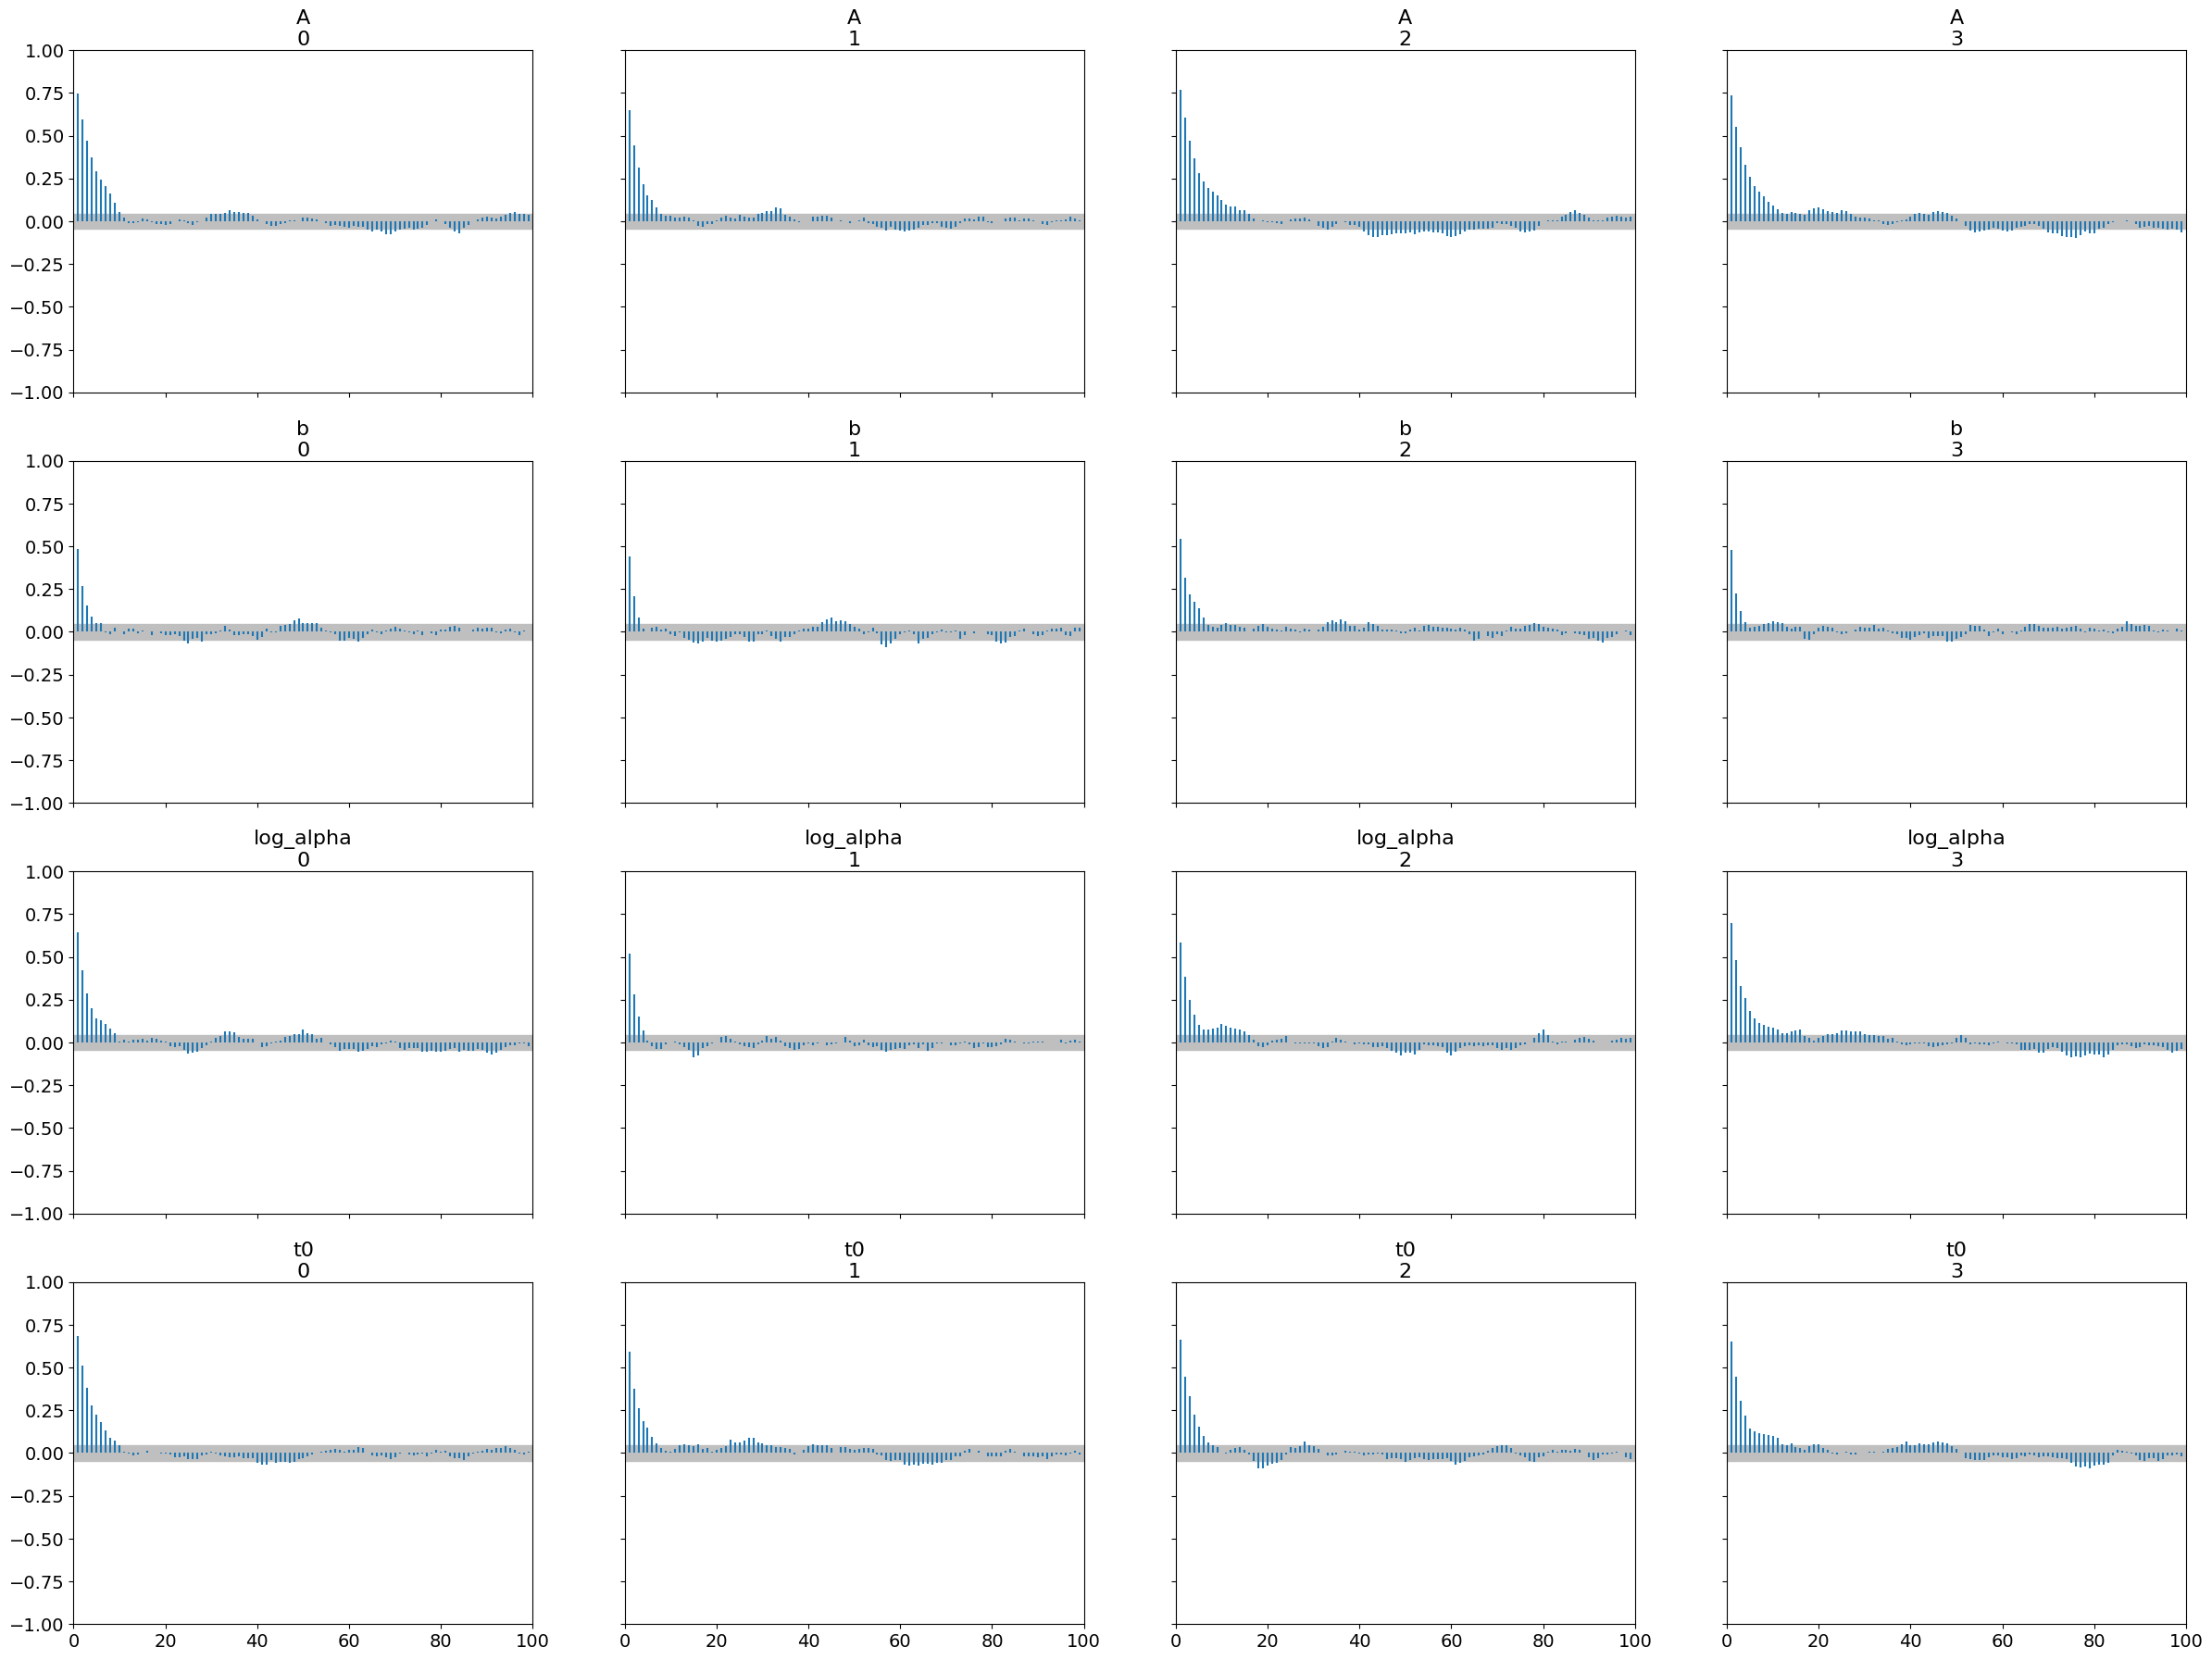

In [11]:
# Plot of the autocorrelation times
az.plot_autocorr(trace, combined=False)

In [12]:
# Explore the result
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [13]:
# Get the keys for parameters of the posterior
par_keys = list(trace['posterior'].data_vars.keys())

# Associate indexes with a dictionary
par_indexes = dict(zip(par_keys, range(len(par_keys))))

# Labels and styles for the parameters
par_labels = []
par_u_labels = []
par_colors = []

# Make the parameters labels
for key in par_keys:
    if key == 't0':
        par_labels.append(r'$t_0$')
        par_u_labels.append(r'$time$')
        par_colors.append('lime')
    elif key == 'b':
        par_labels.append(r'$b$')
        par_u_labels.append(r'$flux$')
        par_colors.append('orange')
    elif key == 'A':
        par_labels.append(r'$A$')
        par_u_labels.append(r'$flux$')
        par_colors.append('royalblue')
    elif key == 'log_alpha':
        par_labels.append(r'$\log(\alpha)$')
        par_u_labels.append(r'$\log(1/time)$')
        par_colors.append('rosybrown')

# **CHECK THIS**

In [14]:
# Exclude some chains if there are some to be excluded
# Tell which chains are bad by writing their indexes in the list below
# Leave an empty list if there are not bad chains
#--------------------------------------------------------------
#
# *** THIS SHOULD BE UPDATED AFTER EVERY EXECUTION ***
bad_chains = []

#------------------------------------------------------------

In [15]:
# Given the bad chains, select the good chains
good_chains = [chain for chain in np.array(trace['posterior']['chain']) if chain not in bad_chains]

# Get the diverging indexes (on good chains)
# flatten() puts all chains on one dimension (explore 'trace' above to understand better)
divergence_indexes = np.array(trace['sample_stats']['diverging'][good_chains]).flatten()

# Get all the sampled parameters from all the good chains and select only the non divergent entries
# par_pos[par_index][sample_index]
par_pos = np.array([np.array(trace['posterior'][key][good_chains]).flatten()[divergence_indexes==False]
                    for key in par_keys])

# Swap the axis, to pass all to a corner plot
# sample[sample_index][par_index]
samples = np.swapaxes(par_pos, 0, 1)

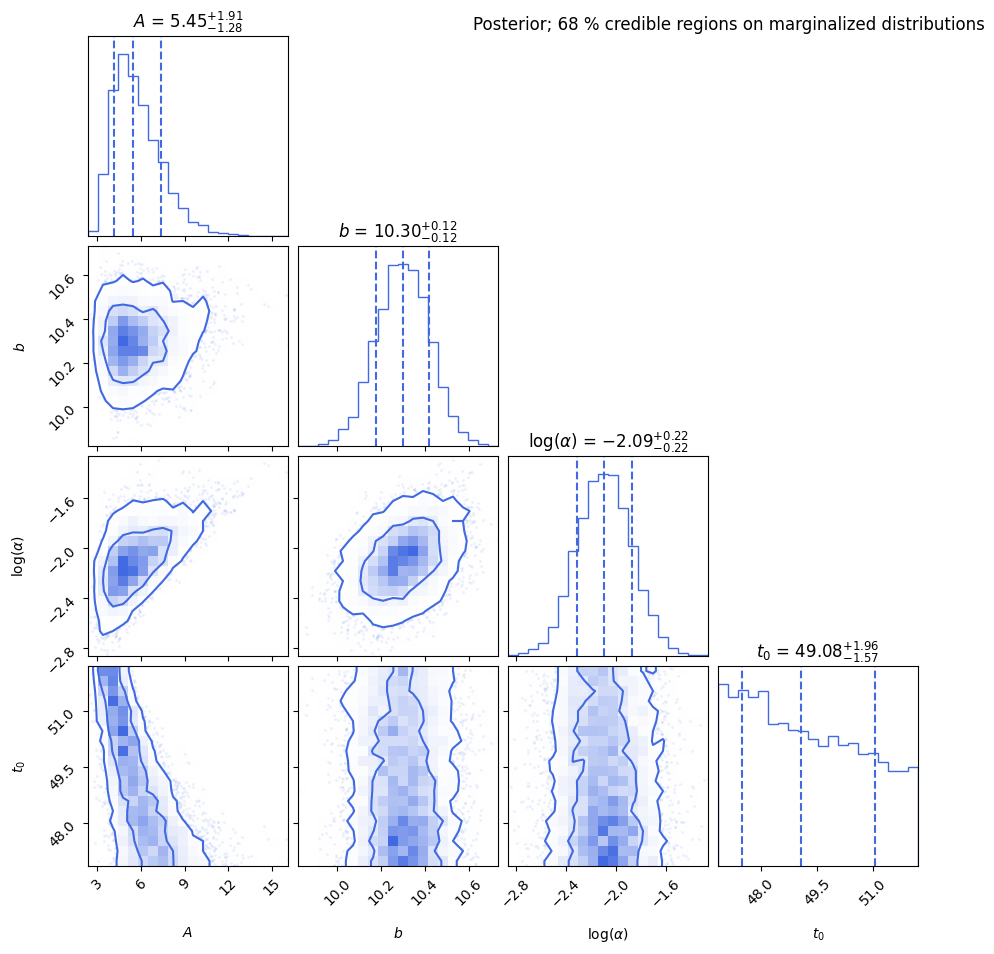

In [16]:
# Make a corner plot with 68 % credible regions on marginalized distributions
fig = corner.corner(samples,
                    labels=par_labels,
                    show_titles=True,
                    color='royalblue',
                    quantiles=[0.16, 0.5, 0.84],
                    levels=(0.68, 0.95))

fig.suptitle("Posterior; 68 % credible regions on marginalized distributions", horizontalalignment='left')

plt.show()

In [17]:
# Styles for the quantiles
quantile_styles = [':', '-.', '--']
quantile_colors = ['magenta', 'red', 'magenta']
quantile_labels = ['5 % quantile', r'$\mu$', '95 % quantile']

# Save the quantiles of the parameters
par_quantiles = []

# 90 % credible regions
for key in par_keys:
    par_quantiles.append(corner.quantile(par_pos[par_indexes[key]], [0.05, 0.5, 0.95]))

par_quantiles = np.array(par_quantiles)

# Construct the result for every parameter using the quantiles
par_values_str = []

for key in par_keys:
    l_ = np.format_float_positional(par_quantiles[par_indexes[key]][1] - par_quantiles[par_indexes[key]][0], 2)
    mu = np.format_float_positional(par_quantiles[par_indexes[key]][1], 2)
    _r = np.format_float_positional(par_quantiles[par_indexes[key]][2] - par_quantiles[par_indexes[key]][1], 2)

    # To escape the '{' and the '}' you have to use {{ and }}
    par_values_str.append(r'${mu}^{{+{_r}}}_{{-{l_}}}$'.format(mu=mu, _r=_r, l_=l_))

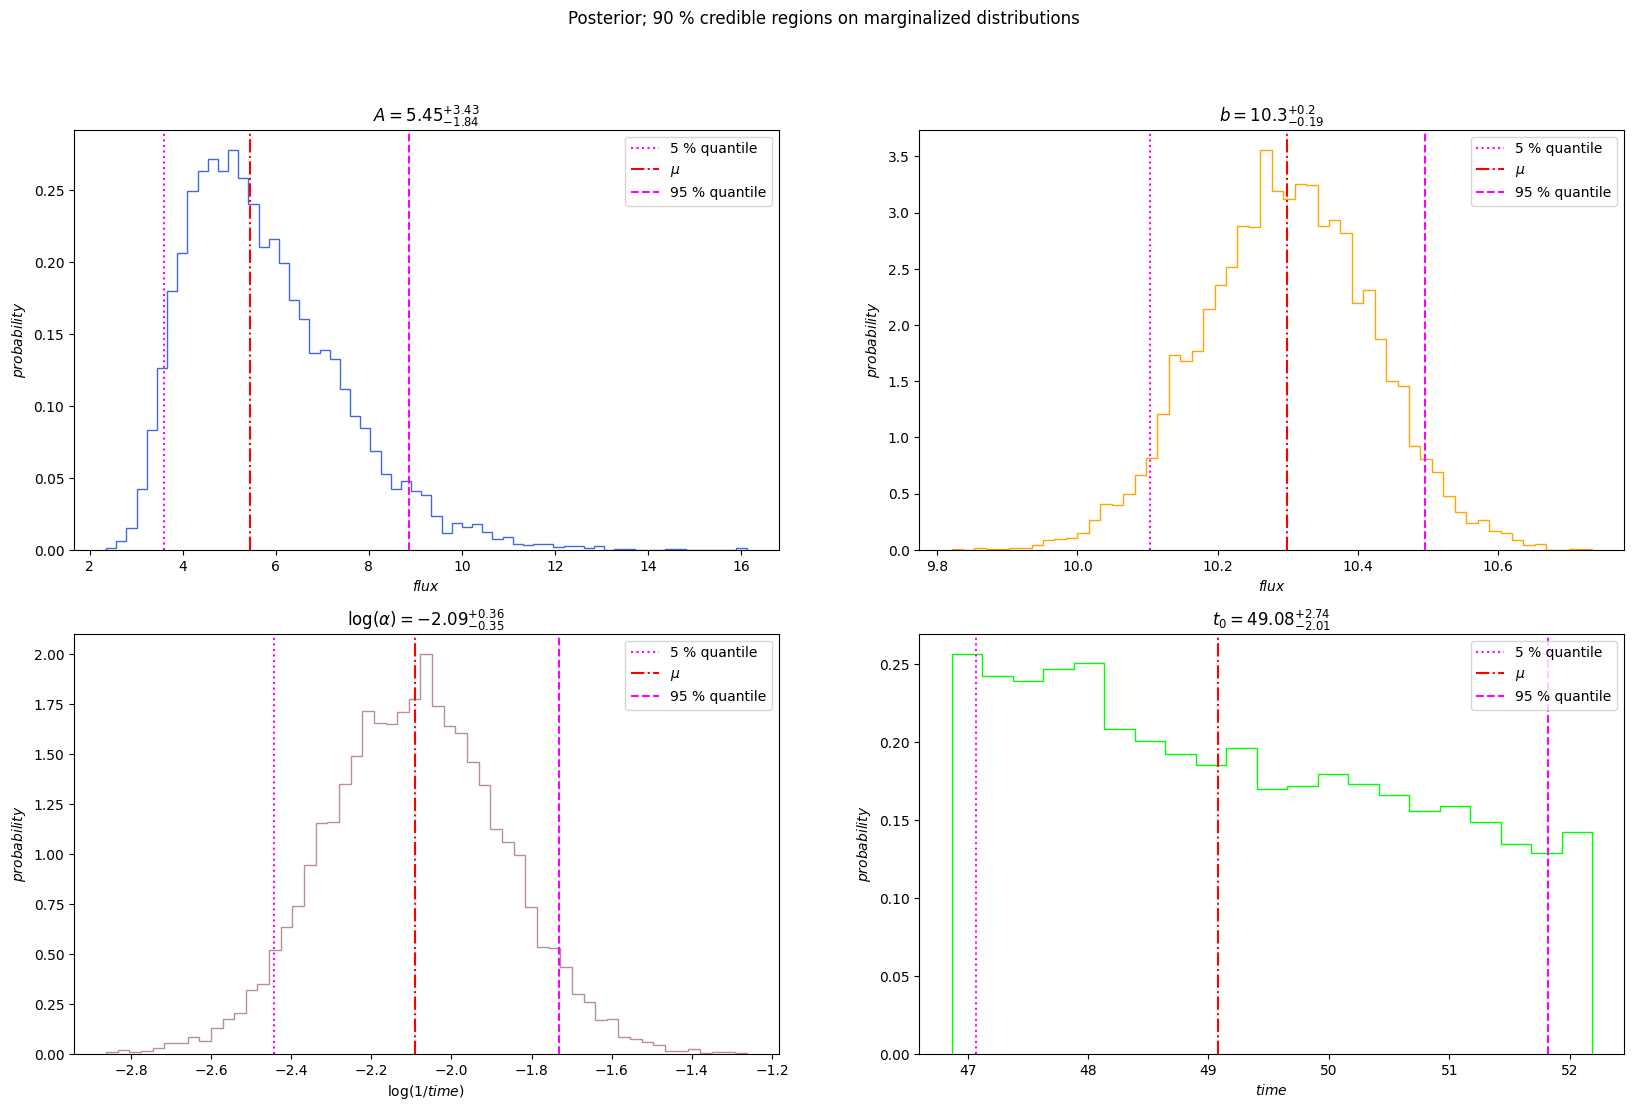

In [18]:
# Plot just the marginalized distributions with 90 % credible regions
n_rows = 2
n_cols = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20,12))

fig.suptitle("Posterior; 90 % credible regions on marginalized distributions")

index = 0
for i in range(n_rows):
    for j in range(n_cols):
        ax[i][j].set_title(par_labels[index] + '$=$' + par_values_str[index])
        ax[i][j].set_xlabel(par_u_labels[index])
        ax[i][j].set_ylabel(r'$probability$')

        ax[i][j].hist(par_pos[index],
                      bins='auto',
                      density=True,
                      color=par_colors[index],
                      histtype='step')
        
        # Quantile lines plotting
        for k in range(len(par_quantiles[index])):
            ax[i][j].axvline(par_quantiles[index][k],
                             color=quantile_colors[k],
                             ls=quantile_styles[k],
                             label=quantile_labels[k])

        ax[i][j].legend()
        
        index += 1

plt.show()

In [19]:
# Select 100 random samples
rnd_samples = samples[np.random.randint(0, len(samples), 100)]

models = np.array([[model_flux(t,
                               rnd_samples[i][par_indexes['t0']],
                               rnd_samples[i][par_indexes['b']],
                               rnd_samples[i][par_indexes['A']],
                               np.exp(rnd_samples[i][par_indexes['log_alpha']]))
                               for t in time_grid]
                               for i in range(len(rnd_samples))])

# Build the bast model
best_model = np.array([model_flux(t,
                                  par_quantiles[par_indexes['t0']][1],
                                  par_quantiles[par_indexes['b']][1],
                                  par_quantiles[par_indexes['A']][1],
                                  np.exp(par_quantiles[par_indexes['log_alpha']][1]))
                                  for t in time_grid])

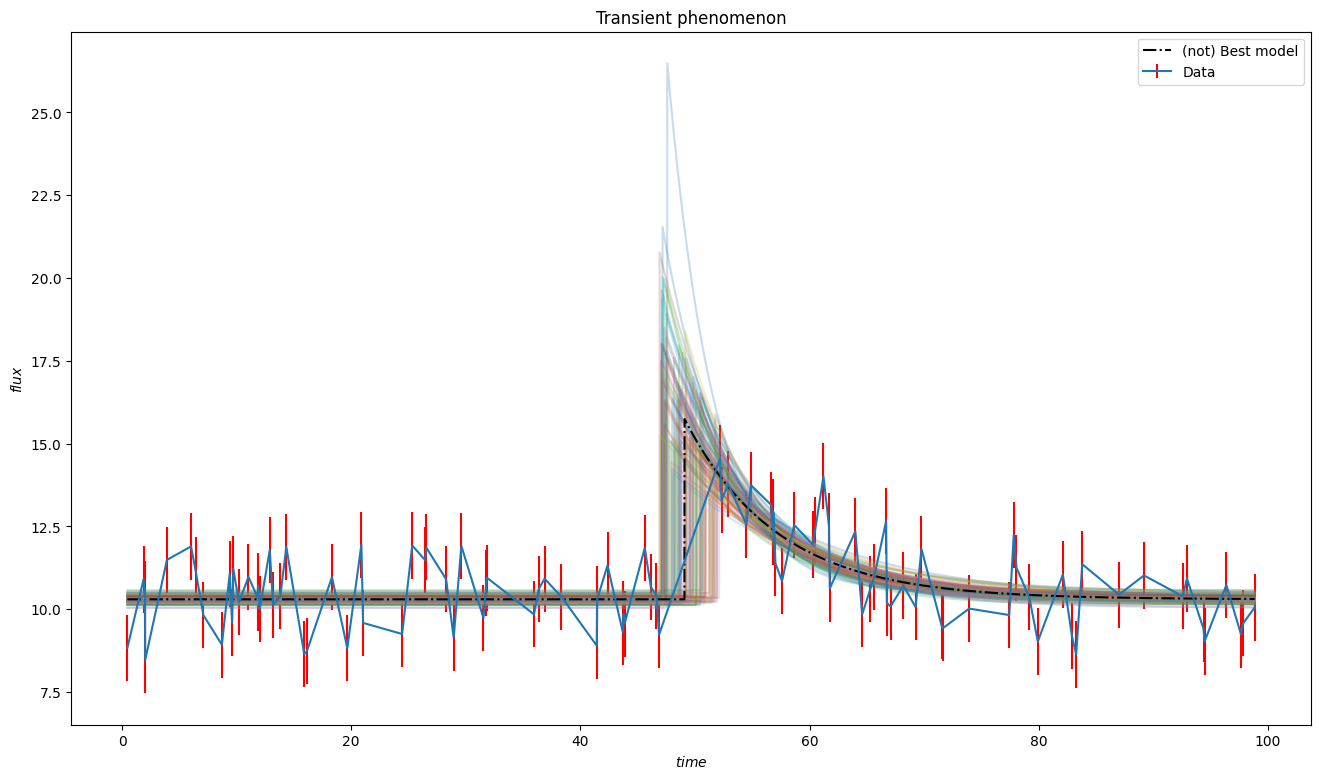

In [20]:
# Plot the models from the randomly selected samples
fig, ax = plt.subplots(figsize=(16,9))

ax.set_title("Transient phenomenon")
ax.set_xlabel("$time$")
ax.set_ylabel("$flux$")

ax.errorbar(time_data, flux_data, yerr=flux_err_data, ecolor='red', label='Data')

# Random selected models
for i in range(len(models)):
    ax.plot(time_grid, models[i], alpha=0.25) # alpha is to set the opacity

# Best model
ax.plot(time_grid, best_model, color='black', label='(not) Best model', ls='-.')

ax.legend()

plt.show()

# Note

The black line isn't the actual best model because it's obtained by taking the median of the marginalized disributions of each parameter. The values of the parameters obtained in this way are **_NOT_ present in the posterior**. Therefore stating that the black line is the **best model** is just **_WRONG_**.

On the other hand, using the marginalized distributions to quote confidence levels for each parameters is correct.